In [130]:
%reset
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import FastICA, PCA
from numpy import dot
import pandas as pd
import seaborn as sns
np.random.seed(0)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [131]:
# Generate sample data
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

In [132]:
# Mix the Signals
S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise
S /= S.std(axis=0)  # Standardize data

# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

print("Signal Matrix : ", S.shape)
print("Mix Matrix : ", A.shape)
print("Transform Matrix: ", X.shape)
print("Mean of Transformed : ", X.mean())

Signal Matrix :  (2000, 3)
Mix Matrix :  (3, 3)
Transform Matrix:  (2000, 3)
Mean of Transformed :  0.21366672951061594


In [133]:
# Compute ICA
ica = FastICA(n_components=3)
S_ica = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

In [134]:
# For comparison, compute PCA
pca = PCA(n_components=3)
S_pca = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

In [135]:
#Hyper Parameters for Gradient
num_epoch = 20000
learning_rate = 0.00003

def np_sig(x):return  1 /(1+(np.exp(-x)))
def np_tanh(x): return np.tanh(x)

In [136]:
# For comparsion ICA with gradient (gradient)
w_sig_grad = np.eye(3)
for iter in range(num_epoch):
    grad = np.linalg.inv(w_sig_grad.T) + dot(np_sig(dot(X,w_sig_grad)).T,X)
    w_sig_grad = w_sig_grad + learning_rate * grad
S_sig_grad = dot(X, w_sig_grad)

In [137]:
# For comparsion ICA with gradient (adam)
w_sig_adam = np.eye(3)
v_sig_adam = np.zeros_like(w_sig_adam)
m_sig_adam = np.zeros_like(w_sig_adam)

for iter in range(num_epoch):
    grad = np.linalg.inv(w_sig_adam.T) + dot(np_sig(dot(X,w_sig_adam)).T,X)
    
    m_sig_adam = 0.9 * m_sig_adam + (1-0.9) * grad
    v_sig_adam = 0.999 * v_sig_adam + (1-0.999) * grad ** 2
    
    m_hat = m_sig_adam/(1-0.9)
    v_hat = v_sig_adam/(1-0.999)
    w_sig_adam = w_sig_adam + learning_rate*0.0007/np.sqrt(v_hat + 1e-30) * m_hat   

S_sig_adam = dot(X,w_sig_adam)

In [138]:
# For comparsion ICA with gradient another method
w_tanh_grad = np.eye(3)
for current_iter in range(num_epoch):
    u = dot(X,w_tanh_grad)
    U = np_tanh(u)
    g = np.linalg.inv(w_tanh_grad.T) - (2/len(X)) * dot(X.T,U)
    w_tanh_grad = w_tanh_grad + learning_rate *g
S_tanh_grad = dot(X,w_tanh_grad)

In [139]:
# For comparsion ICA with gradient another method (adam)
w_tanh_adam = np.eye(3)
m_tanh_adam = np.zeros_like(w_tanh_adam)
v_tanh_adam = np.zeros_like(w_tanh_adam)

for current_iter in range(num_epoch):
    u = dot(X,w_tanh_adam)
    
    U = np_tanh(u)
    grad = np.linalg.inv(w_tanh_adam.T) - (2/len(X)) * dot(X.T,U)
    
    m_tanh_adam = 0.9 * m_tanh_adam + (1-0.9) * grad
    v_tanh_adam = 0.999 * v_tanh_adam + (1-0.999) * grad ** 2
    
    m_hat = m_tanh_adam/(1-0.9)
    v_hat = v_tanh_adam/(1-0.999)
    w_tanh_adam = w_tanh_adam + learning_rate/np.sqrt(v_hat + 1e-30) * m_hat   
    
S_tanh_adam = dot(X,w_tanh_adam)

In [140]:
import tensorflow as tf
tf.set_random_seed(0)

S_tf = None
x_tf = tf.placeholder(shape=[2000,3],dtype=tf.float32)
w_tf = tf.Variable(tf.eye(3))

u_tf = tf.matmul(x_tf,w_tf)
U_tf = tf.nn.tanh(u_tf)
g_tf = tf.linalg.inv(tf.transpose(w_tf)) - (2/len(X)) * tf.matmul(tf.transpose(x_tf),U_tf)
w_tf_update = [tf.assign(w_tf,w_tf+learning_rate*g_tf)]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for iter in range(num_epoch):
        sess_result = sess.run(w_tf_update,feed_dict={x_tf:X.astype(np.float32)})
    S_tf = sess.run(u_tf,feed_dict={x_tf:X})

In [141]:
print('Original Data Shape',S.shape)
print('Fast ICA Data Shape',S_ica.shape)
print('PCA Data Shape',S_pca.shape)
print('Sigmoid Grad Data Shape',S_sig_grad.shape)
print('Sigmoid Adam Data Shape',S_sig_adam.shape)
print('Tanh Grad Data Shape',S_tanh_grad.shape)
print('Tanh Adam Data Shape',S_tanh_adam.shape)
print('TF Tanh Grad Data Shape',S_tf.shape)

Original Data Shape (2000, 3)
Fast ICA Data Shape (2000, 3)
PCA Data Shape (2000, 3)
Sigmoid Grad Data Shape (2000, 3)
Sigmoid Adam Data Shape (2000, 3)
Tanh Grad Data Shape (2000, 3)
Tanh Adam Data Shape (2000, 3)
TF Tanh Grad Data Shape (2000, 3)


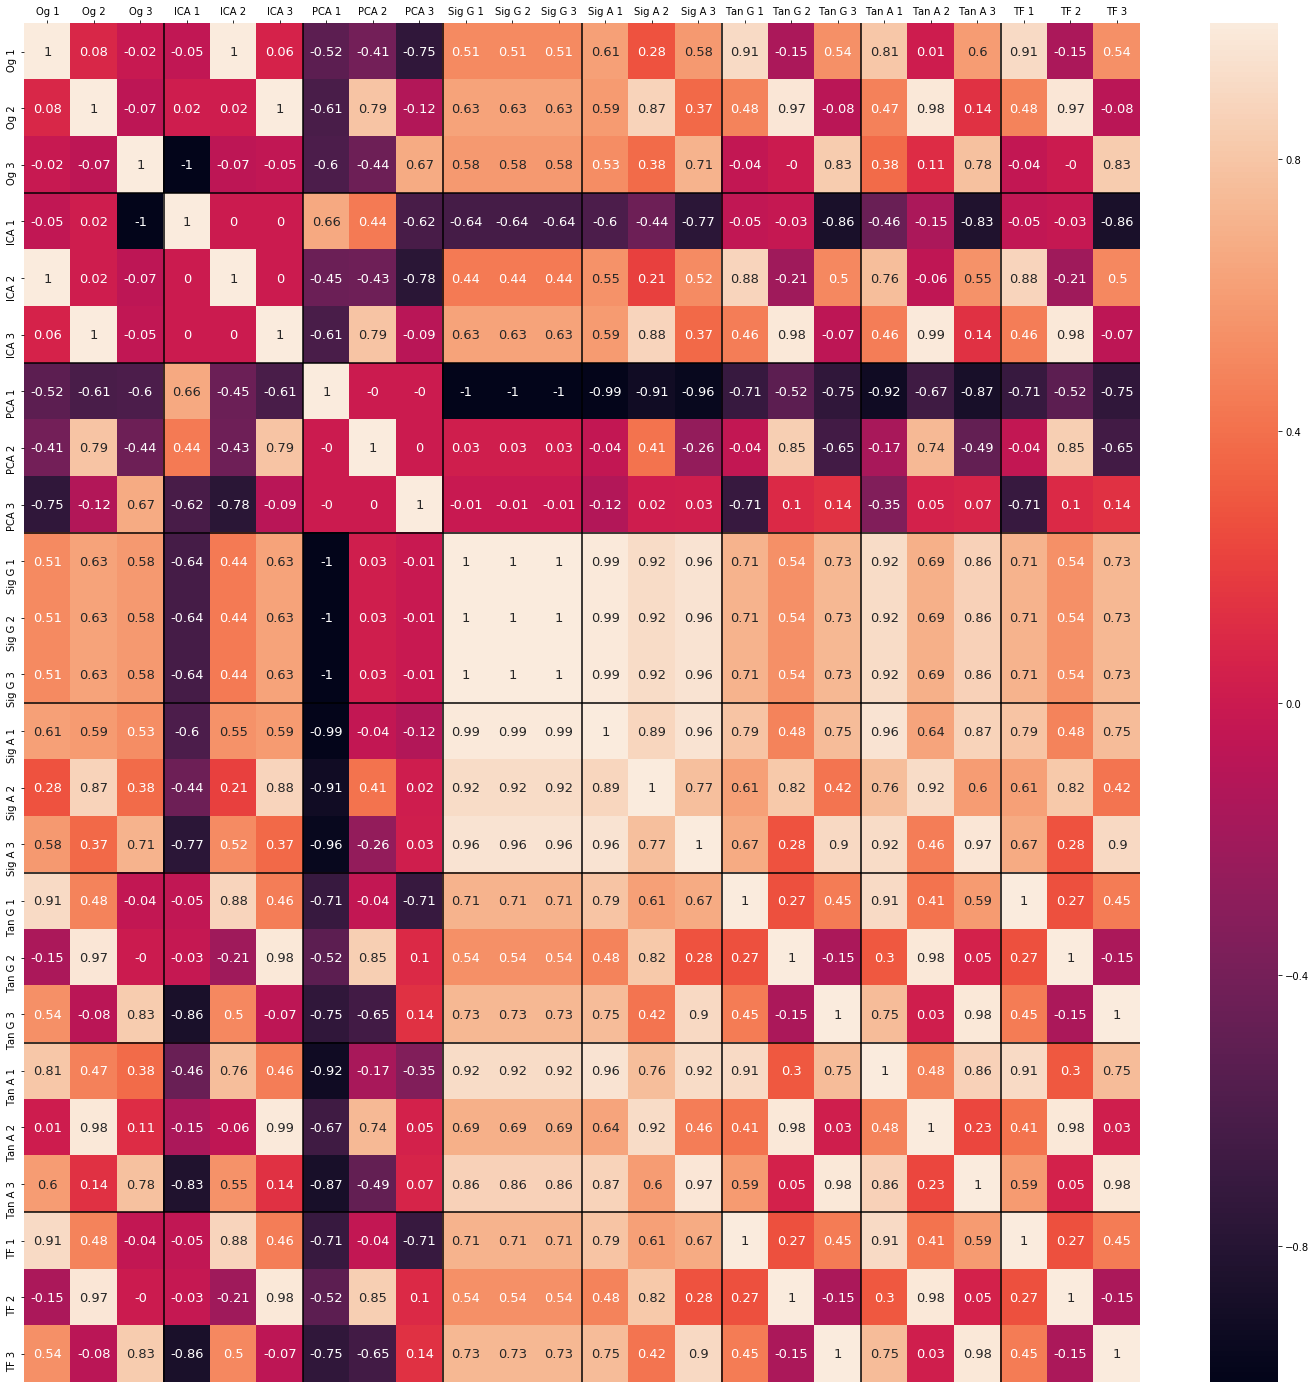

In [147]:
df = pd.DataFrame(np.hstack((S, S_ica, S_pca,S_sig_grad,S_sig_adam,S_tanh_grad,S_tanh_adam,S_tf)),
                 columns=['Og 1','Og 2','Og 3',
                         'ICA 1','ICA 2','ICA 3',
                         'PCA 1','PCA 2','PCA 3',
                         'Sig G 1','Sig G 2','Sig G 3',
                         'Sig A 1','Sig A 2','Sig A 3',
                         'Tan G 1','Tan G 2','Tan G 3',
                         'Tan A 1','Tan A 2','Tan A 3',
                       'TF 1','TF 2','TF 3',
                         ])
plt.figure(figsize=(25,25))
ax = sns.heatmap(np.around(df.corr(),2),annot=True,annot_kws={"size": 13})
ax.xaxis.tick_top()
ax.vlines([3, 6, 9,12,15,18,21], *ax.get_ylim())
ax.hlines([3, 6, 9,12,15,18,21], *ax.get_xlim())

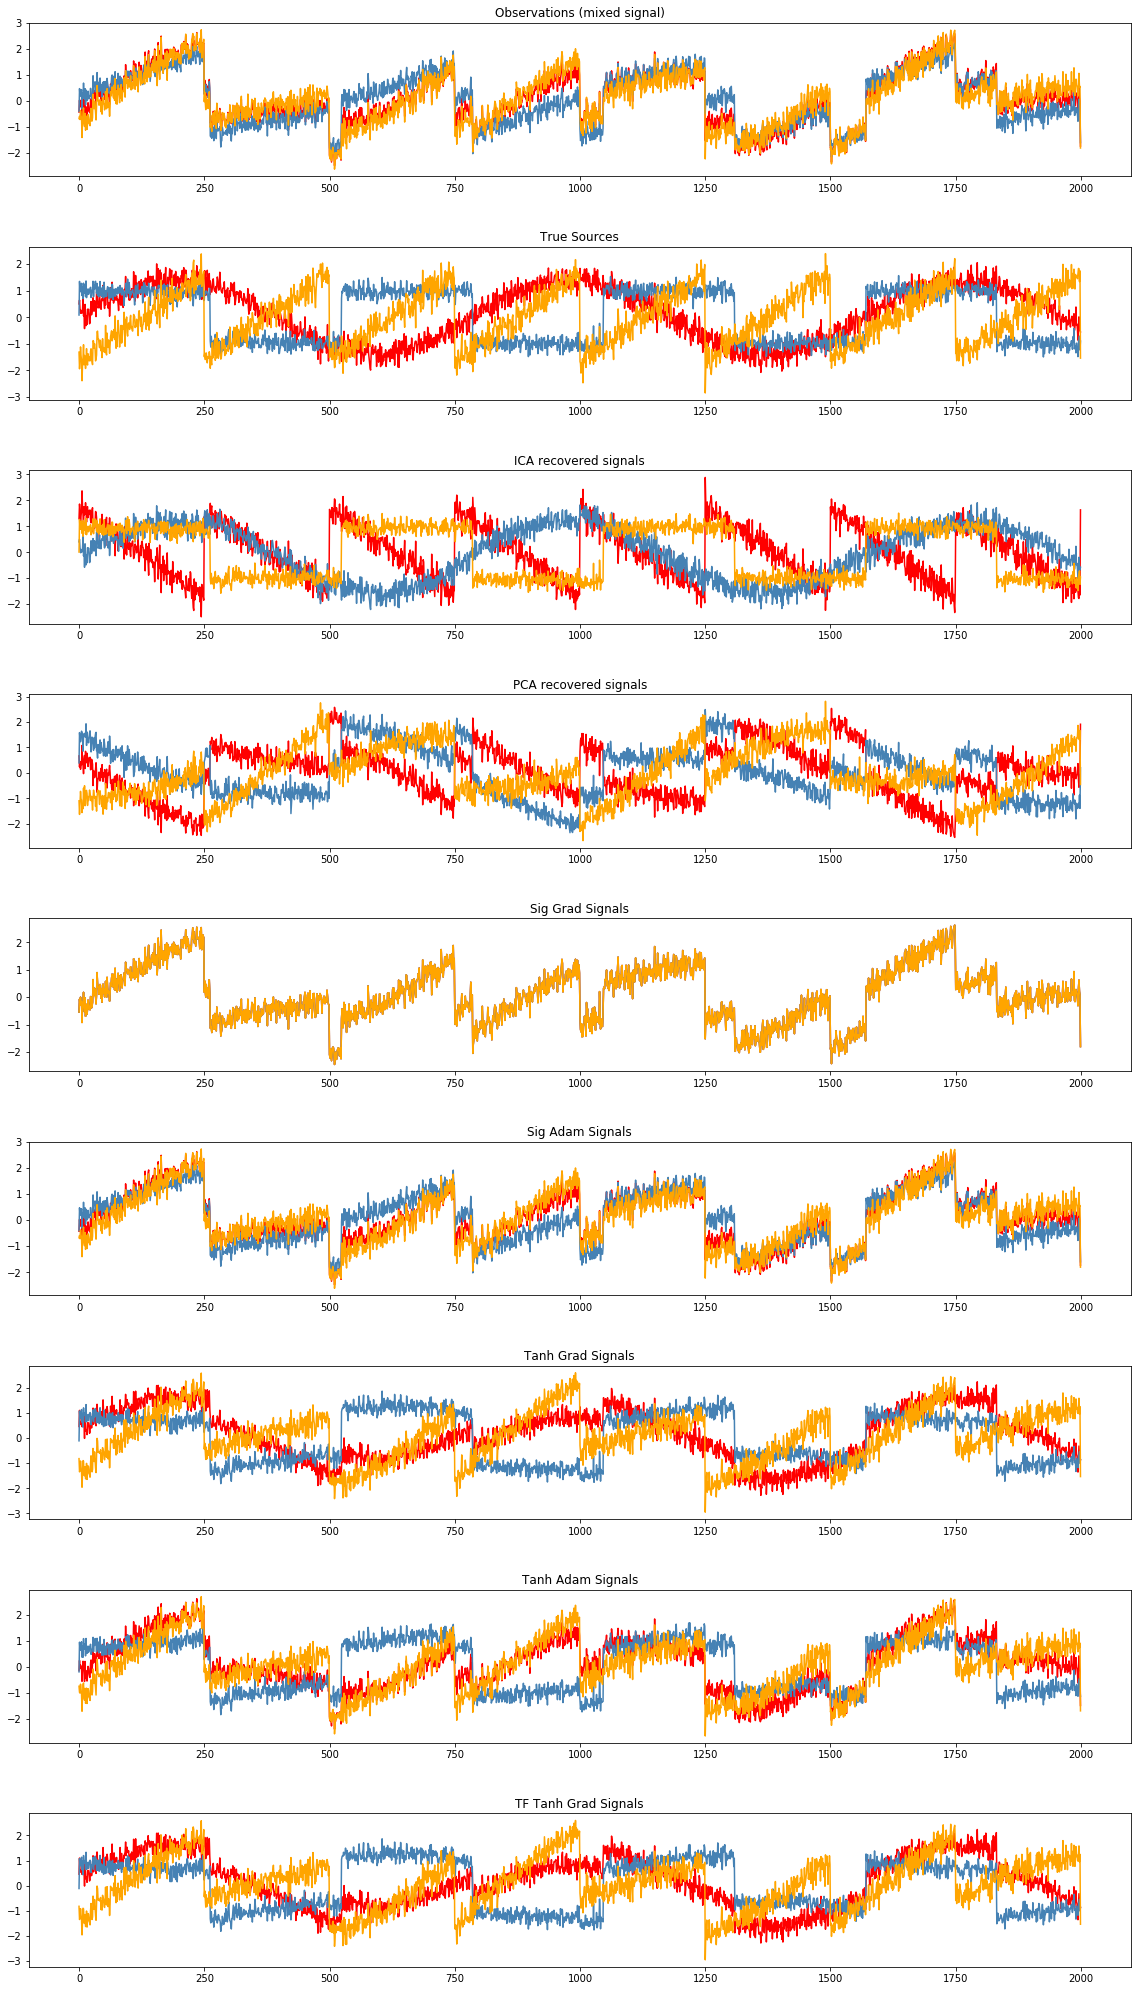

In [143]:
# #############################################################################
# Plot results
plt.figure(figsize=(18,30))
models = [X, S, S_ica, 
          S_pca,S_sig_grad,S_sig_adam,
          S_tanh_grad,S_tanh_adam,S_tf]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals',
        'Sig Grad Signals',
        'Sig Adam Signals',
        'Tanh Grad Signals',
        'Tanh Adam Signals',
        'TF Tanh Grad Signals',
        ]
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(9, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig/np.std(sig), color=color)
plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()